<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/ML_Stocks_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install -U scikit-learn

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

In [7]:
df0 = pd.read_csv("sp500sub.csv",index_col = 'Date',parse_dates = True)

In [8]:
df0.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [12]:
df = df0[df0['Name'] == 'IBM'][['Close']].copy()

In [13]:
df.head()

,Close
Date,
2010-01-04,132.449997
2010-01-05,130.850006
2010-01-06,130.000000
2010-01-07,129.550003
2010-01-08,130.850006


In [14]:
df['LogClose'] = np.log(df['Close'])

In [15]:
df['DiffLogClose'] = df['LogClose'].diff()

In [16]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [19]:
series = df['DiffLogClose'].to_numpy()[1:]

T = 21
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print("X shape: ",X.shape," Y shape: ",Y.shape)

X shape:  (2241, 21)  Y shape:  (2241,)


In [21]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [24]:
#Boolean index
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

#First T values are no predictable
#diff - first value is null
train_idx[:T + 1] = False

In [34]:
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

df.head()

,Close,LogClose,DiffLogClose,ShiftLogClose
Date,,,,
2010-01-04,132.449997,4.886205,NaN,NaN
2010-01-05,130.850006,4.874052,-0.012154,4.886205
2010-01-06,130.000000,4.867534,-0.006517,4.874052
2010-01-07,129.550003,4.864067,-0.003468,4.867534
2010-01-08,130.850006,4.874052,0.009985,4.864067


In [46]:
def one_step_and_mulstep_forecast(model,name):
  model.fit(XTrain,YTrain)
  print("One-step forecast: ", name)

  print("1 step forecast ")

  #Store one step forecast
  df.loc[train_idx,f"{name}_1step_train"] = prev[train_idx] + model.predict(XTrain)
  df.loc[test_idx,f"{name}_1step_test"] = prev[test_idx] + model.predict(XTest)

  #Multistep forecast
  multistep_predictions = []

  X_last = XTest[0]

  while len(multistep_predictions) < NTest:
    p = model.predict(X_last.reshape(1,-1))[0]
    multistep_predictions.append(p)

    X_last = np.roll(X_last,-1)
    X_last[-1] = p

  last_train = train.iloc[-1]['LogClose']
  df.loc[test_idx,f"{name}_multistep_test"] = last_train + np.cumsum(multistep_predictions)

  cols = [
      'LogClose',
      f'{name}_1step_train',
      f'{name}_1step_test',
      f"{name}_multistep_test"
  ]

  df[cols].plot(figsize = (15,5))
  df.iloc[-100:][cols].plot(figsize = (15,5));

One-step forecast:  LR
1 step forecast 


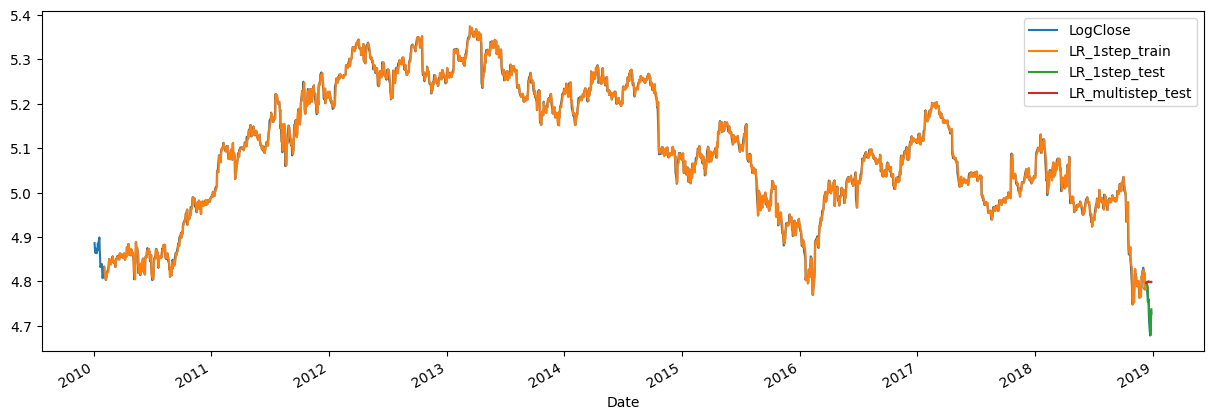

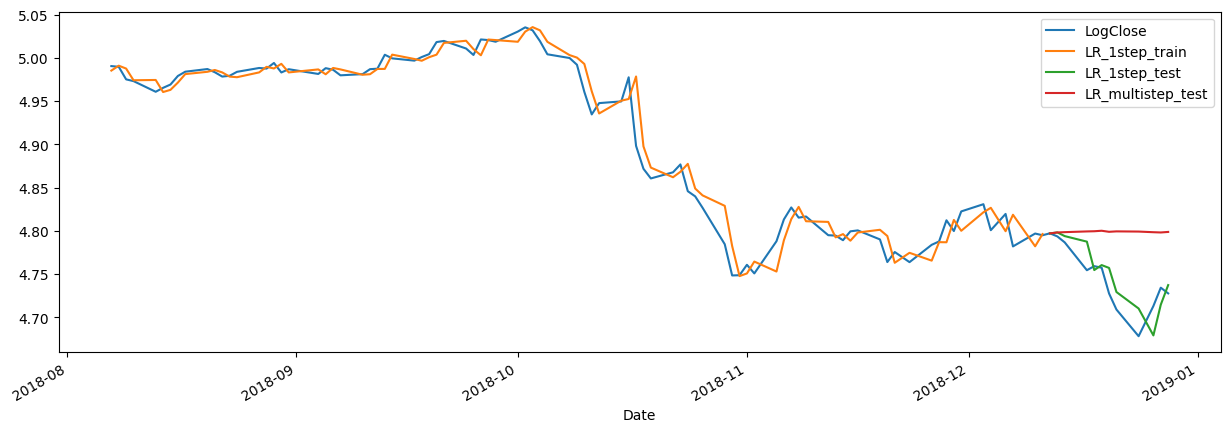

In [47]:
one_step_and_mulstep_forecast(LinearRegression(),"LR")

One-step forecast:  SVR
1 step forecast 


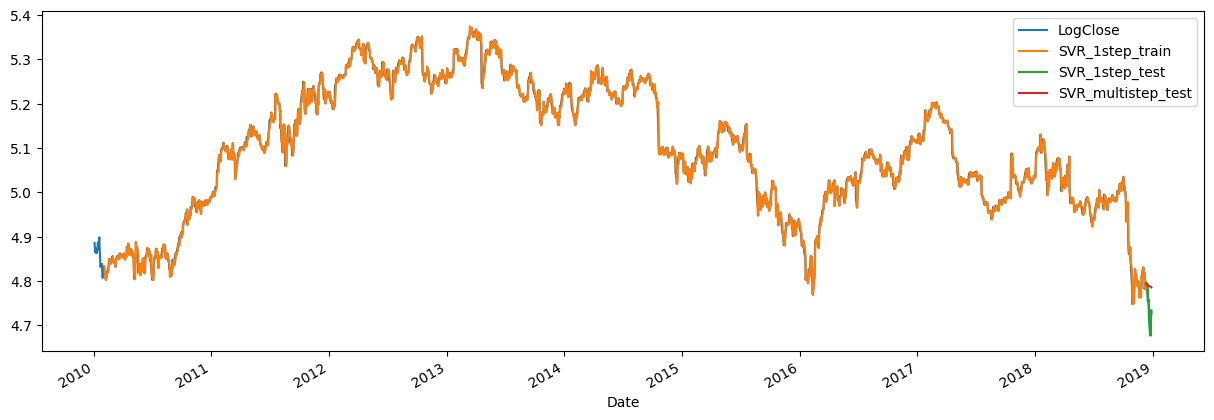

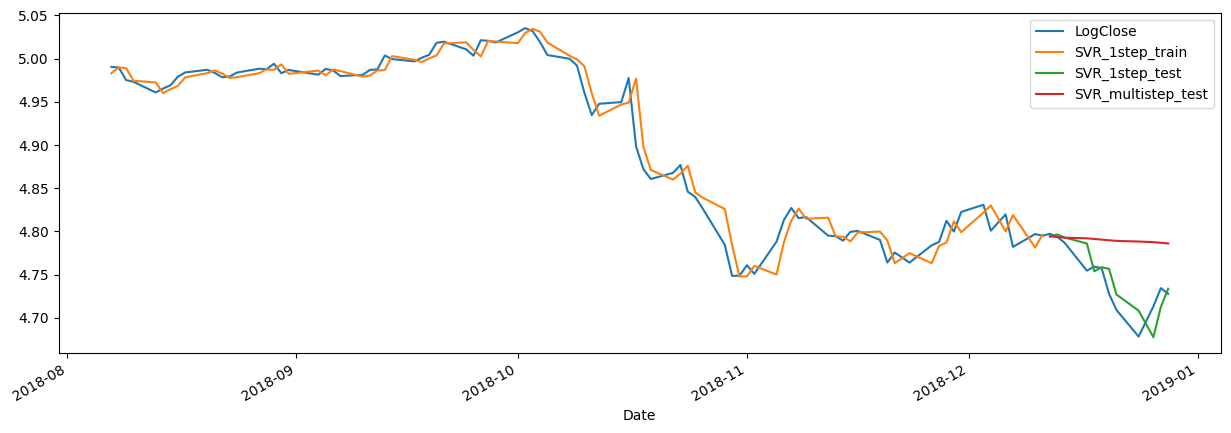

In [73]:
one_step_and_mulstep_forecast(SVR(),"SVR")

One-step forecast:  RF
1 step forecast 


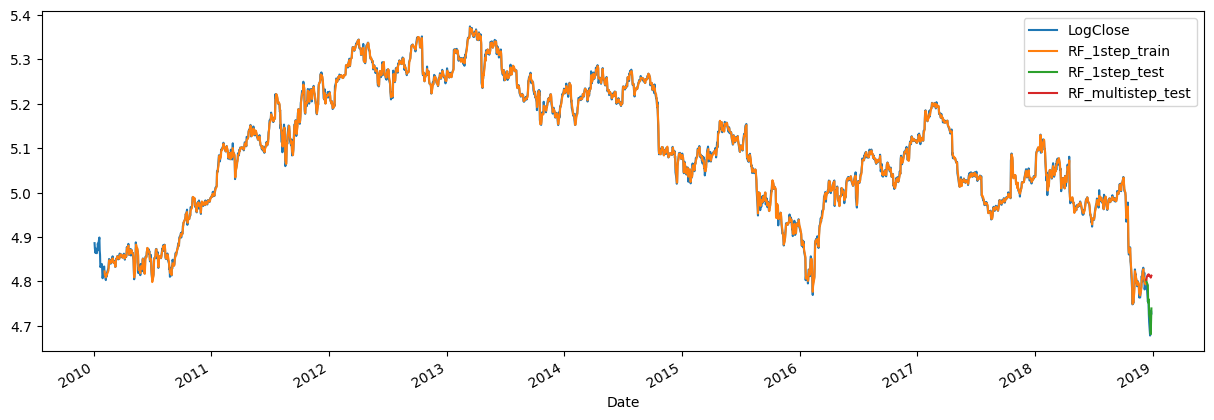

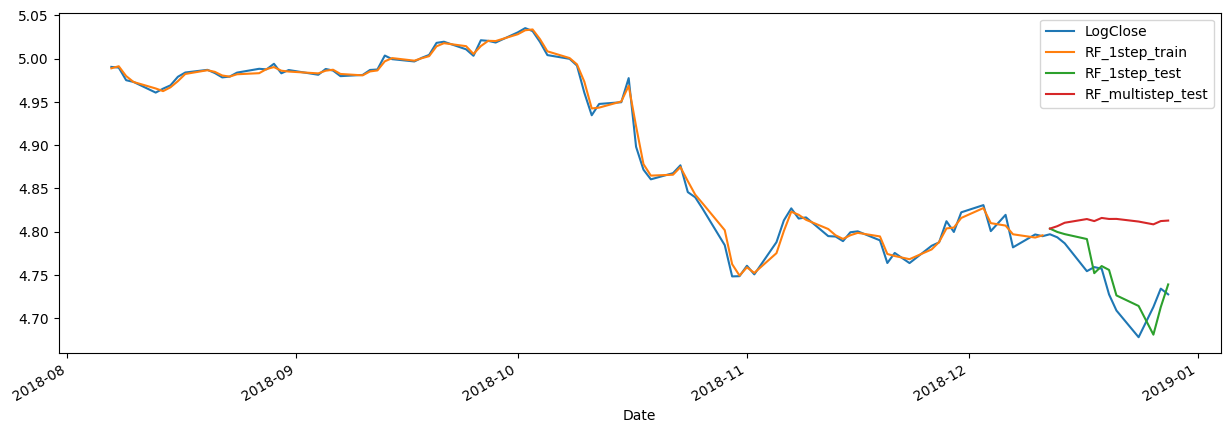

In [74]:
one_step_and_mulstep_forecast(RandomForestRegressor(),"RF")

In [53]:
#Make multi-output supervised dataset
Tx = T
Ty = NTest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)

In [54]:
XTrain_m,YTrain_m = X[:-1],Y[:-1]
XTest_m,YTest_m = X[-1:],Y[-1:]

In [71]:
def multioutput_forecast(model,name):
    model.fit(XTrain_m,YTrain_m)
    pred = model.predict(XTest_m).flatten()

    last_train = train.iloc[-1]['LogClose']
    df.loc[test_idx,f"{name}_multioutput"] = last_train + \
    np.cumsum(pred)

    #MAPE
    test_log_pass = df.iloc[-NTest:]['LogClose']
    mape = mean_absolute_percentage_error(
        test_log_pass, df.loc[test_idx,f'{name}_multioutput']
    )
    print("multi-output MAPE: ", mape)
    mape2 = mean_absolute_percentage_error(
        test_log_pass,df.loc[test_idx,f'{name}_multistep_test']
    )
    print("multi-step   MAPE: ",mape2)

    cols = [
        'LogClose',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput'
    ]

    df[cols].plot(figsize = (15,5))
    df.iloc[-100:][cols].plot(figsize = (15,5));

multi-output MAPE:  0.011998190671272594
multi-step   MAPE:  0.01142632609085105


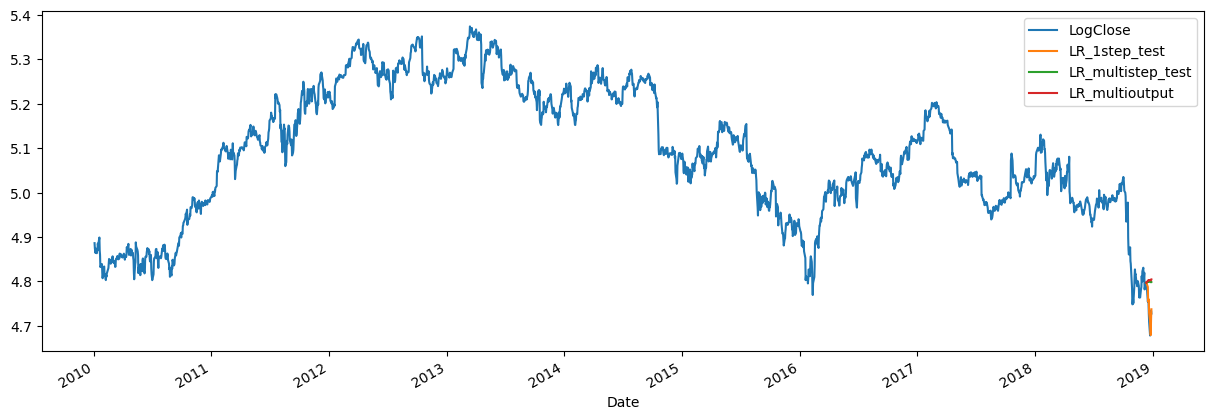

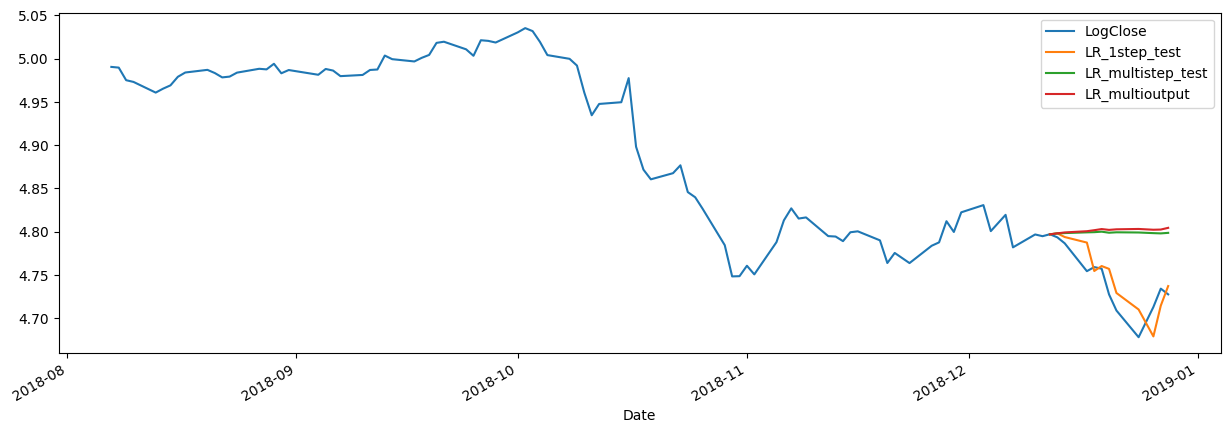

In [72]:
multioutput_forecast(LinearRegression(),"LR")

multi-output MAPE:  0.011452796930114676
multi-step   MAPE:  0.014123122029217332


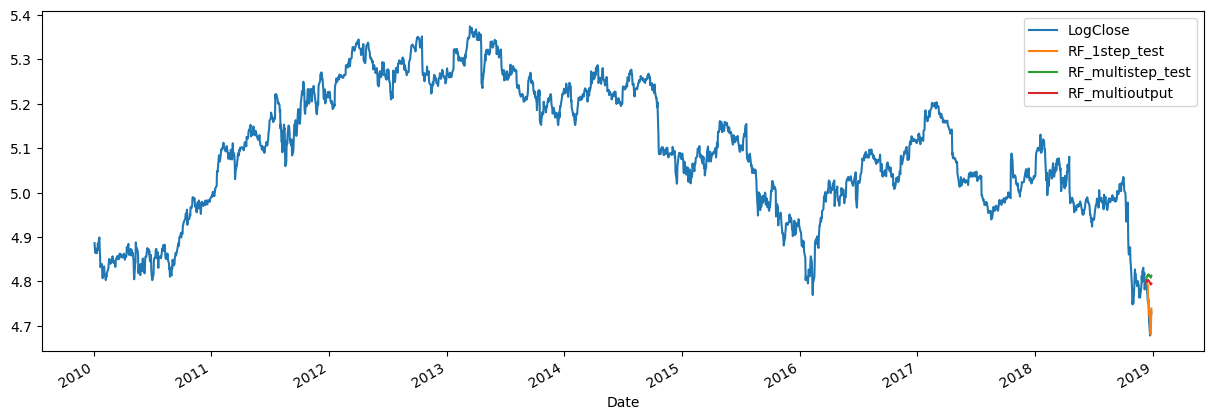

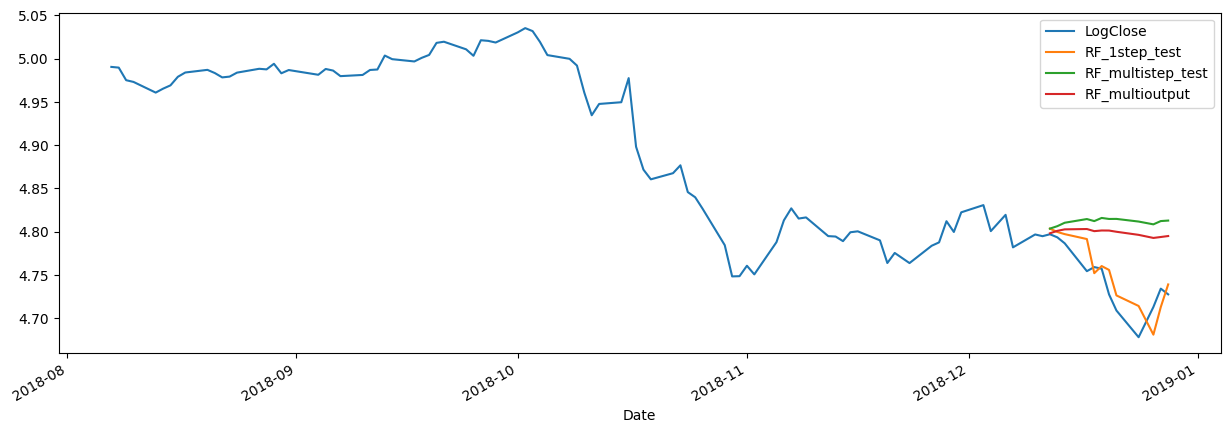

In [76]:
multioutput_forecast(RandomForestRegressor(),'RF')